In [20]:
class Animal:
    def __init__(self):
        print("Animal is created.")

class Mammal(Animal):
    def __init__(self):
        self.a=33
        super().__init__()
        print("Mammal is created.")

class Dog(Mammal):
    def __init__(self):
        
        self.a=10
        
        super().__init__()
        
        print("Dog is created.")
    def bark(self):
            print("Dog is created ssssss")
dog = Dog()
dog.bark()

Animal is created.
Mammal is created.
Dog is created.
Dog is created ssssss


In [9]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
print(torch.version.cuda)

12.1


In [11]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [12]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [13]:
import torch
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt 
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
image = Image.open("C:/Users/39327/Desktop/test/1.png")
image = np.array(image.convert("RGB"))

sam2_model = build_sam2(model_cfg,checkpoint, device='cuda')

predictor = SAM2ImagePredictor(sam2_model)

In [25]:
input_box = np.array([150, 120, 300, 366])
#print(xywh_numpy[0])
xywh_numpy1 = xywh_numpy[0]
print(xywh_numpy1)
print(input_box)
print(input_box.shape)

[     121.97      162.33      290.59         374]
[150 120 300 366]
(4,)


In [28]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=xywh_numpy1[None, :],
    #box=None,
    multimask_output=False,
)
print(masks.shape )

(1, 500, 574)


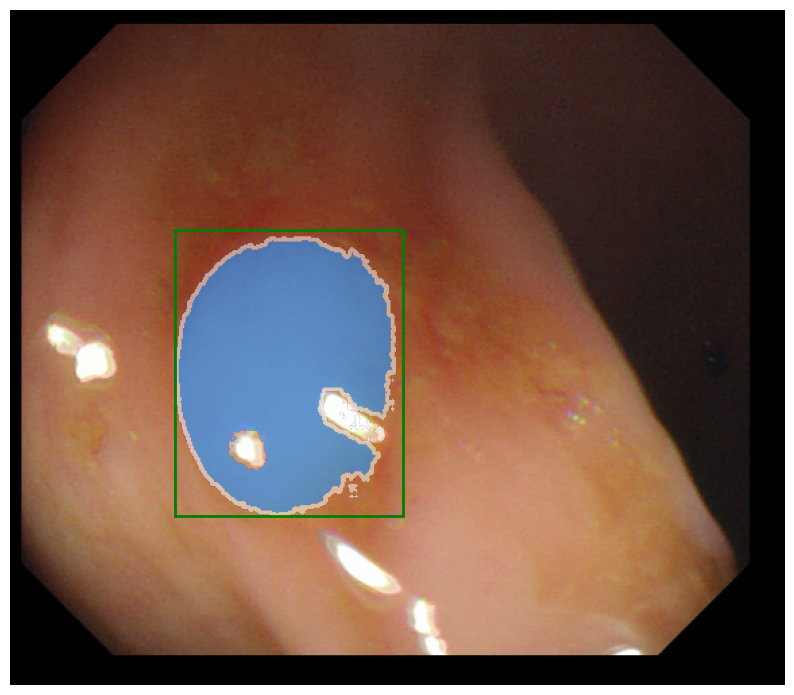

In [29]:
show_masks(image, masks, scores, box_coords=xywh_numpy1)

In [24]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8x.yaml").load("yolov8x.pt")
model=YOLO("C:/Users/39327/runs/detect/train10/weights/best.pt")
# Run batched inference on a list of images
results = model("1.png",device='cuda',conf=0.2)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    print("boxess",boxes)
    import numpy as np

    xywh_numpy = boxes.xyxy.cpu().numpy()
    # print(xywh_numpy)
    # print(xywh_numpy.shape)
    # print(type(xywh_numpy))
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs 
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    #result.save(filename="result.jpg")  # save to
    xywh_tuple = tuple(xywh_numpy[0])
    print(xywh_tuple)
    print(type(xywh_tuple))


image 1/1 C:\Users\39327\Desktop\test\1.png: 576x640 1 polyp, 98.0ms
Speed: 11.0ms preprocess, 98.0ms inference, 19.0ms postprocess per image at shape (1, 3, 576, 640)
boxess ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9609], device='cuda:0')
data: tensor([[121.9750, 162.3344, 290.5875, 373.9969,   0.9609,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (500, 574)
shape: torch.Size([1, 6])
xywh: tensor([[206.2812, 268.1656, 168.6125, 211.6625]], device='cuda:0')
xywhn: tensor([[0.3594, 0.5363, 0.2937, 0.4233]], device='cuda:0')
xyxy: tensor([[121.9750, 162.3344, 290.5875, 373.9969]], device='cuda:0')
xyxyn: tensor([[0.2125, 0.3247, 0.5063, 0.7480]], device='cuda:0')
(121.975, 162.33437, 290.5875, 373.99686)
<class 'tuple'>
